# This project aims to visualise the Brexit referendum result

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from matplotlib.gridspec import GridSpec
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

%matplotlib inline

/Users/chengyanggu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/chengyanggu/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
brexit_url = 'https://en.wikipedia.org/wiki/Brexit'
response = requests.get(brexit_url)

In [3]:
parsed_url = BeautifulSoup(response.text, 'html.parser')

In [4]:
table = parsed_url.find('table', class_ = 'wikitable')

In [5]:
brexit_data = []
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all(['th', 'td'])
    cols = [col.text.strip() for col in cols]
    brexit_data.append(cols)

In [6]:
brexit_table = pd.DataFrame(brexit_data[1:], columns = brexit_data[0])
brexit_table = brexit_table.iloc[[0, 1]]

brexit_table['%'] = pd.to_numeric(brexit_table['%'])

In [7]:
by_region_data = parsed_url.find('table', class_ = 'wikitable sortable')

In [8]:
region_data = []
rows = by_region_data.find_all('tr')
for row in rows:
    cols = row.find_all(['th', 'td'])
    cols = [col.text.strip() for col in cols]
    region_data.append(cols)

In [9]:
# convert into a table and clean data
region_table = pd.DataFrame(region_data)
region_table.drop([0, 2, 3, 4, 5, 8], axis =1, inplace = True)
region_table.drop([0, 1], axis = 0, inplace = True)
region_table.reset_index(drop = True, inplace = True)
region_table.rename(columns = {1: 'Region', 6: 'Remain', 7: 'Leave'}, inplace = True)

In [10]:
def scaler(string):
    string = string.str.replace('%', '')
    string = pd.to_numeric(string)
    return string

In [11]:
region_table[['Remain', 'Leave']] = region_table[['Remain', 'Leave']].apply(scaler)

In [12]:
# determine the referendum result
def result(row):
    if row['Remain'] > row['Leave']:
        return 0
    else:
        return 1
    
region_table['Result'] = region_table.apply(result, axis = 1)

In [13]:
gb_electoral = gpd.read_file('/Users/chengyanggu/Desktop/Python_Dataset/gb_eer.json')
ni_electoral = gpd.read_file('/Users/chengyanggu/Desktop/Python_Dataset/ni_eer.json')

In [14]:
# clean data for Northern Ireland
ni_electoral[['id', 'ID']] = 'N07000001'
ni_electoral['EER13CDO'] = 12
ni_electoral.drop(['Area_SqKM', 'OBJECTID'], axis = 1, inplace = True)
ni_electoral.rename(columns = {'ID': 'EER13CD', 'NAME': 'EER13NM'}, inplace = True)

In [15]:
# merge GB and NI
df_electoral = pd.concat([gb_electoral, ni_electoral], ignore_index=True)

In [16]:
# fuzzy match to give result of the election to geo data
def fuzzy_match_columns(col1, col2):
    matches = []
    for name1 in col1:
        match = process.extractOne(name1, col2)
        if match[1] >= 80:  # Adjust threshold as needed
            matches.append(match[0])
        else:
            matches.append(None)
    return matches

# Perform fuzzy matching between Name1 column in df1 and Name2 column in df2
region_table['Region'] = fuzzy_match_columns(region_table['Region'], df_electoral['EER13NM'])

In [17]:
# clean data to match
region_table.loc[1, 'Region'] = 'Eastern'

In [18]:
df_electoral = pd.merge(df_electoral, region_table, left_on='EER13NM', right_on='Region', how='left')

In [19]:
df_electoral.drop(['Region', 'Remain', 'Leave'], axis = 1, inplace = True)
df_electoral.loc[11, 'EER13NM'] = 'Northern Ireland'
region_table.loc[5, 'Region'] = 'Northern Ireland'

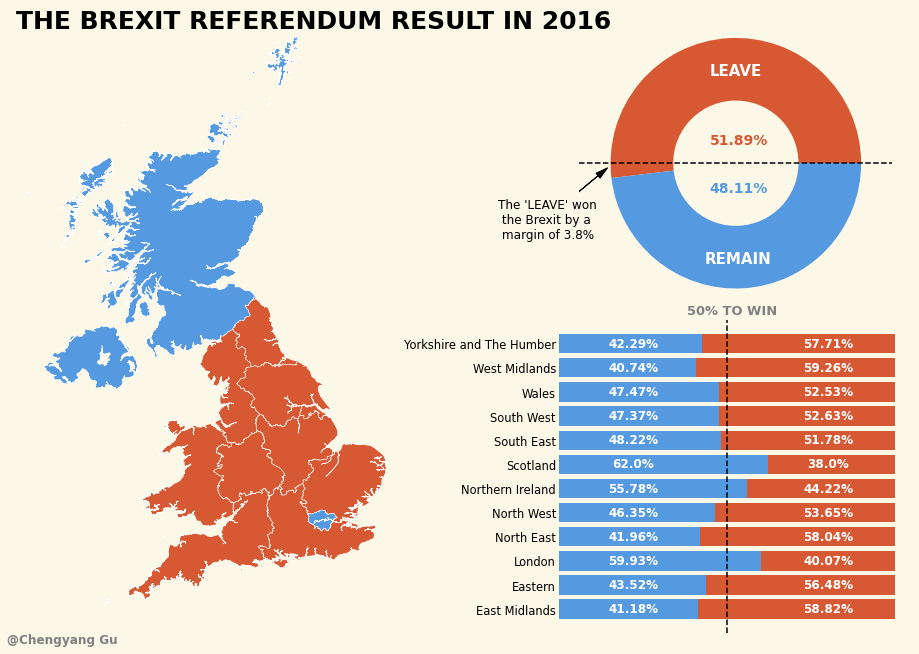

In [20]:
# set the layout of the visualisation
fig = plt.figure(figsize=(15, 9))
gs = GridSpec(4, 6, figure=fig)

fig.patch.set_facecolor('#fbf8e7')

# add subplots
ax1 = fig.add_subplot(gs[0:4,0:4])
ax2 = fig.add_subplot(gs[0:2,4:6])
ax3 = fig.add_subplot(gs[2:4,4:6])

color_dict = {
    1: '#d65933',
    0: '#5599e0'
}

colors = [color_dict.get(value, 'gray') for value in df_electoral['Result']]
df_electoral.plot(ax = ax1, linewidth = 0.5, edgecolor='white', color = colors)
ax1.set_aspect(1.5)
ax1.axis('off')


ax2.pie(brexit_table['%'], colors = ['#d65933', '#5599e0'],
       wedgeprops={'width': 0.5})
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax2.text(-0.21, 0.7, 'LEAVE', size = 15, weight = 'bold', color = 'white')
ax2.text(-0.25, -0.8, 'REMAIN', size = 15, weight = 'bold', color = 'white')
ax2.text(-0.21, 0.15, '51.89%', size = 14, weight = 'bold', color = '#d65933')
ax2.text(-0.21, -0.23, '48.11%', size = 14, weight = 'bold', color = '#5599e0')
ax2.arrow(-1.7, -0.6, 0.6, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax2.text(-1.9, -0.6, "The 'LEAVE' won \n the Brexit by a\n margin of 3.8%", size = 12)

ax3.barh(region_table['Region'], region_table['Remain'], color = '#5599e0')
ax3.barh(region_table['Region'], region_table['Leave'], left = region_table['Remain'], color = '#d65933')
ax3.axvline(x = 50, color='black', linestyle='--', linewidth=1.5)
ax3.text(38, 12.2, '50% TO WIN', size = 13, weight = 'bold', color = 'grey')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(axis='both', which='both', length=0)
ax3.yaxis.set_tick_params(labelsize=11.5)
ax3.set_xticks([])

ax3.set_facecolor('#fbf8e7')

for region, remain, leave in zip(region_table['Region'], region_table['Remain'], region_table['Leave']):
    ax3.text(22, region, str(remain) + '%', ha = 'center', va = 'center', color = 'white', weight = 'bold', size = 12)
    ax3.text(80, region, str(leave) + '%', ha = 'center', va = 'center', color = 'white', weight = 'bold', size = 12)

fig.text(0.16, 0.95, 'THE BREXIT REFERENDUM RESULT IN 2016', size = 25, weight = 'bold')
fig.text(0.152, 0, '@Chengyang Gu', weight = 'bold', size = 12, color = 'gray')
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()